# Data Analysis to show algorithmic bias

The following two blocks were given in the assignment to get data about gender representation in the tate and sort it into categories by medium.

In [280]:
import pandas as pd
artwork = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2021/2021-01-12/artwork.csv')
artists = pd.read_csv("https://github.com/tategallery/collection/raw/master/artist_data.csv")

artwork.to_csv("artwork.csv", index = False)
artists.to_csv("artists.csv", index = False)

In [281]:
import pandas as pd
artwork = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2021/2021-01-12/artwork.csv')
artists = pd.read_csv("https://github.com/tategallery/collection/raw/master/artist_data.csv")

artwork["id"] = artwork["artistId"]
artwork = artwork[["id", "year", "acquisitionYear", "title", "medium"]]
artists = artists[["id", "gender"]]
df = pd.merge(artwork, artists)

def dimension(med_string):
    """
    Assign a dimension to a given piece of artwork based on the description
    of the medium, supplied as a string. 
    Media that include the words "paper", "canvas", "oil", or "paint" are assumed 
    2D. 
    Media that are not 2d and include the words "bronze", "stone", or "ceramic" are 
    assumed 3D. 
    Otherwise, the media is "Other/Unknown"
    
    @param med_string: str, the original medium
    @return dim: one of "2D", "3D", or "Other/Unknown" according to the rules above. 
    """
    if type(med_string) != str:
        med_string = str(med_string)
    med_string = med_string.lower()
    if any([w in med_string for w in ["paper", "canvas", "oil", "paint"]]):
        return "2D"
    elif any([w in med_string for w in ["bronze", "stone", "ceramic"]]):
        return "3D"
    else:
        return "Other/Unknown"

df["dimension"] = [dimension(m) for m in df["medium"]]
df = df[["title","acquisitionYear", "gender", "dimension"]]

With this data, I made a graph examining percentage of work by female artists by year in the Tate museum split into categories of 2D, 3D, and other/unknown.

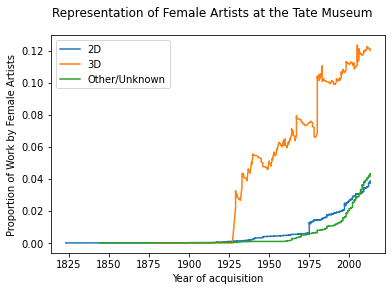

In [282]:

import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np


#sort by year, then gender, then dimension
df_sort=df.sort_values(["acquisitionYear", "gender", "dimension"])

#make plot, add title and axes
fig, ax=plt.subplots(1)
fig.suptitle("Representation of Female Artists at the Tate Museum")
ax.set(xlabel="Year of acquisition")
ax.set(ylabel="Proportion of Work by Female Artists")

def f(dimension):
    """
    This function finds the cumulative totals of a specific 
    dimension of art done by males, females, and total 
    amount of art ownded by the tate, and plots the 
    percentage of work that is by females for each year
    
    @param- dimension: a set of the above dataframe containing
    one specific dimension of work
    
    """
    
    #split by gender
    female=dimension["gender"]=="Female"
    male=dimension["gender"]=="Male"
    
    #calculate cumulative sum of each, add to get total
    fNum=female.cumsum()
    mNum=male.cumsum()
    pieces=fNum+mNum
    
    #find percent of work that is female
    percent=fNum/pieces
    
    #plot percent of art thats female by year
    ax.plot(dimension['acquisitionYear'], percent, 
            label=dimension['dimension'].unique()[0])
    
    
    

#group by dimension 
df_sort.groupby(["dimension"]).apply(f)
ax.legend()



## Health Care Discrepancies

Next, I will get medical data that was originally used to create a machine learning model that predicts health outcomes. The data I will be using includes demographics, metrics of health, and insurance claims. This was provided to me.

In [283]:
import pandas as pd
url = "https://gitlab.com/labsysmed/dissecting-bias/-/raw/master/data/data_new.csv?inline=false"
df = pd.read_csv(url)

In [284]:
df.shape

(48784, 160)

Additional given information about column meanings. 

- `risk_score_t` is the algorithm's risk score assigned to a given patient. 
- `cost_t` is the patient's medical costs in the study period. 
- `race` is the patient's self-reported race. The authors filtered the data to include only `white` and `black` patients. 
- `gagne_sum_t` is the total number of chronic illnesses presented by the patient during the study period. 
- `dem_female` is a patient sex indicator, with `1` indicating female patients and `0` indicating male patients. 

In [2]:
cols = ['risk_score_t', 'cost_t', 'gagne_sum_t','race',  'dem_female']

In the graph below, The vertical axis gives the *percentile risk* of patients assigned by the algorithm, and the horizontal axis gives the average number of chronic illnesses presented by patients in the corresponding risk percentile**.

For example, White men in the 80th risk score percentile presented, on average, approximately two chronic illnesses. The number of chronic illnesses presented by a patient is contained in the `"gagne_sum_t"` column of the data. 

Text(0.5, 1.0, 'Female')

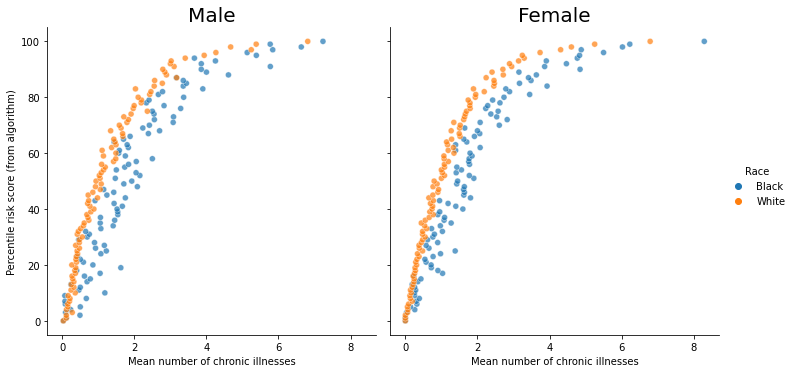

In [287]:
# your solution


#map- for making legend capitalized later
df=df.rename(columns={"race":"Race"})
#capitalize black and white
df["Race"]=df["Race"].map({"black":"Black", "white":"White"})

#y values: risk score percentile 
df['y']=((df["risk_score_t"].rank()/len(df)*100).round()).astype(int)

#group by race, sex, and risk score, then get mean 
#number of illnesses for each
new_=df.groupby(['Race', 'dem_female', 'y'])[['gagne_sum_t']].mean()

#make that into a new df to use means
new_df=pd.DataFrame(new_.reset_index())


plots=sns.relplot(data=new_df,
                  x="gagne_sum_t",
                  y="y",
                  hue="Race",
                  col="dem_female",
                  alpha=.7,
                  legend=True)
                  

#Set Labels and Titles
plots.axes[0][0].set(xlabel="Mean number of chronic illnesses",
                    ylabel="Percentile risk score (from algorithm)",)
plots.axes[0][0].set_title("Male", fontsize=20)

plots.axes[0][1].set(xlabel="Mean number of chronic illnesses")
plots.axes[0][1].set_title("Female", fontsize=20)

Conclusions: 

If Patient A is Black and Patient B is white, and they are equally sick, patient B is more likely to be referred into the high-risk care management program. Splitting the plots by gender shows that for male and female patients, White patients have higher percentile risk scores than Black patients with the same number of chronic illnesses.

As shown above, there is a clear disparity between health care of Black and White patients, and I attempted to find the source. The column above that was risk score, calculating health risk based on overall level of health was trained using total medical cost as the target variable. 

I will use linear regression to estimate the difference in generated medical costs between White and Black patients in this data set. The two following cells were given.

In [233]:
# Step 1: run, do not modify
df = pd.read_csv(url)

In [245]:
# Step 2: run, do not modify
cols = ['cost_t',
        'race',
        'dem_female',
        'dem_age_band_18-24_tm1',
        'dem_age_band_25-34_tm1',
        'dem_age_band_35-44_tm1',
        'dem_age_band_45-54_tm1',
        'dem_age_band_55-64_tm1',
        'dem_age_band_65-74_tm1',
        'dem_age_band_75+_tm1',
        'alcohol_elixhauser_tm1',
        'anemia_elixhauser_tm1',
        'arrhythmia_elixhauser_tm1',
        'arthritis_elixhauser_tm1',
        'bloodlossanemia_elixhauser_tm1',
        'coagulopathy_elixhauser_tm1',
        'compdiabetes_elixhauser_tm1',
        'depression_elixhauser_tm1',
        'drugabuse_elixhauser_tm1',
        'electrolytes_elixhauser_tm1',
        'hypertension_elixhauser_tm1',
        'hypothyroid_elixhauser_tm1',
        'liver_elixhauser_tm1',
        'neurodegen_elixhauser_tm1',
        'obesity_elixhauser_tm1',
        'paralysis_elixhauser_tm1',
        'psychosis_elixhauser_tm1',
        'pulmcirc_elixhauser_tm1',
        'pvd_elixhauser_tm1',
        'renal_elixhauser_tm1',
        'uncompdiabetes_elixhauser_tm1',
        'valvulardz_elixhauser_tm1',
        'wtloss_elixhauser_tm1',
        'cerebrovasculardz_romano_tm1',
        'chf_romano_tm1',
        'dementia_romano_tm1',
        'hemiplegia_romano_tm1',
        'hivaids_romano_tm1',
        'metastatic_romano_tm1',
        'myocardialinfarct_romano_tm1',
        'pulmonarydz_romano_tm1',
        'tumor_romano_tm1',
        'ulcer_romano_tm1']

df = df[cols]

Next I numerically encoded the race column.

In [246]:
# Step 3: 
from sklearn import preprocessing

le=preprocessing.LabelEncoder()
df["race"]=le.fit_transform(df["race"])


Next I split the data into target data `y` (cost_t col of the dataframe) and predictor data X (all other cols)

In [247]:
# Step 4: 
X=df.drop(["cost_t"], axis=1)
y=df["cost_t"]

Next, I did a train test split of X and Y, using 20% of the data as test data.

In [292]:
# Step 5: 
from sklearn.model_selection import train_test_split

X_train, X_test=train_test_split(X, test_size=.2, random_state=2021)
y_train, y_test=train_test_split(y, test_size=.2, random_state=2021)

Next I created a linear regression model and fit it to the training data and evaluated the score of the model.

In [293]:
# Step 6: 

from sklearn.linear_model import LinearRegression

LR=LinearRegression()
LR.fit(X_train,y_train)

training_score=LR.score(X_train,y_train)
testing_score=LR.score(X_test,y_test)

print("Training score = " + str(training_score))
print("Testing score = " + str(testing_score))

Training score = 0.12629789734544883
Testing score = 0.12415443228313183


These scores are typically very low, so the model is still performing as intended. I am not worried about overfitting here because the training score and testing score differ by less than .003.

Next, I examined the coef_ attribute of the model, which estimates the effect that a specific column of the predictor data has on the target data. Below, I estimated the effect of the race column.

In [251]:
# Step 8:
coef=LR.coef_
print("Coefficient of race: " + str(coef[0]))

Coefficient of race: 579.903174777751


The estimated difference in cost between Black and white patients is $579.90 (Black patients costing 579.90 less than hite patients). If the risk score above is calculated using past medical costs, and Black patients cost less than white patients on average because of less access to medical resources, Black patients will also recieve a lower risk score. 